# **Britanova cord blood dataset**

In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import parmap

from raptcr.hashing import TCRDistEncoder
from raptcr.neighbors import NeighborEnrichment
from raptcr.indexing import FlatIndex

from raptcr.background import generate_olga_sequences_multi, generate_olga_sequences, matched_property_sampling, get_frequency_distributions
from raptcr.constants.parsing import parse_britanova_repertoires

In [8]:
import random
from raptcr.background import SyntheticBackground, directed_sampling

df = parse_britanova_repertoires('./data/britanova/A5-S14.txt.gz')
# sb = SyntheticBackground(repertoire=df, )
sampled = directed_sampling(df, int(df.shape[0]*10))

In [10]:
sampled.to_csv('./analysis/background_testing/full_matched/A5-S14_background_full.txt', sep='\t', index=False)

**Example repertoires**

In [2]:
df = parse_britanova_repertoires('./data/britanova/A5-S14.txt.gz')
size_background = int(df.shape[0] * 10)

### Random background model

In [3]:
from raptcr.background import _setup_olga_models

genomic_data, generative_model = _setup_olga_models()
# rndm_bckgrnd = generate_olga_sequences_multi(total=size_background, chunks=10000, genomic_data=genomic_data, generative_model=generative_models, ncpus=8)

In [17]:
from raptcr.constants.modules.olga.sequence_generation import SequenceGenerationVDJ
from raptcr.constants.modules.olga import olga_directed

# # genomic_data, generative_model = _setup_olga_models()
seq_gen_model = olga_directed.SequenceGenerationVDJ(generative_model, genomic_data)

def get_gene_id(gene, ref):
    gene = gene.split('*')[0]
    assert gene in list(ref.gene), f'Unknown gene: {vgene}.'
    return int(random.choice(ref[ref['gene']==gene].index))

def olga_sequence(seq_gen_model, vgene=None, jgene=None, vref=None, jref=None):
    if vgene is not None:
        vid = int(get_gene_id(vgene, vref))
    else:
        vid = vgene
    if jgene is not None:
        jid = int(get_gene_id(jgene, jref))
    else:
        jid = jgene
    # recombination = None
    # while recombination is None:
    recombination = seq_gen_model.gen_rnd_prod_CDR3(V=vid, J=jid)
    if recombination is None:
        return None
    else:
        cdr3_nt_out = recombination[0]
        cdr3_aa_out = recombination[1]
        v_out = vref.loc[recombination[2]].v_allele
        j_out = jref.loc[recombination[3]].j_allele
        return (cdr3_nt_out, cdr3_aa_out, v_out, j_out)

# olga_sequence(vgene='TRBV25-1*01', jgene='TRBJ2-4*01')


# olga_sequence(vgene=None, jgene=None, vref=vref, jref=jref)

In [8]:
params_file_name = './raptcr/constants/modules/olga/default_models/human_T_beta/model_params.txt'
marginals_file_name = './raptcr/constants/modules/olga/default_models/human_T_beta/model_marginals.txt'
V_anchor_pos_file ='./raptcr/constants/modules/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv'
J_anchor_pos_file = './raptcr/constants/modules/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv'

genomic_data = load_model.GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

generative_model = load_model.GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file_name)

In [9]:
from raptcr.constants.modules.olga import load_model

def _setup_olga_models():

    params_file_name = './raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/model_params.txt'
    marginals_file_name = './raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/model_marginals.txt'
    V_anchor_pos_file ='./raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv'
    J_anchor_pos_file = './raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv'

    genomic_data = load_model.GenomicDataVDJ()
    genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

    generative_model = load_model.GenerativeModelVDJ()
    generative_model.load_and_process_igor_model(marginals_file_name)
    
    return genomic_data, generative_model

def generate_olga_sequences(n, genomic_data, generative_model):
    seq_gen_model = SequenceGenerationVDJ(generative_model, genomic_data)
    colnames = ['junction','junction_aa','v_call','j_call']
    df = pd.DataFrame([seq_gen_model.gen_rnd_prod_CDR3()[:4] for i in range(n)], columns=colnames)
    df['v_call'] = df['v_call'].apply(lambda x: genomic_data.genV[x][0])
    df['j_call'] = df['j_call'].apply(lambda x: genomic_data.genJ[x][0])
    df['v_gene'] = df['v_call'].apply(lambda x: x.split('*')[0])
    df['j_gene'] = df['j_call'].apply(lambda x: x.split('*')[0])
    return df

def generate_olga_sequences_multi(total, chunks, genomic_data, generative_model, ncpus=1):
    with multiprocessing.Pool(ncpus) as pool:
        seq = parmap.map(
            generate_olga_sequences,
            [chunks] * int(total/chunks),
            genomic_data,
            generative_model,
            pm_parallel=True,
            pm_pool=pool
            )
    return pd.concat(seq).reset_index(drop=True)

def get_frequency_distributions(df):
    vfreq = dict(df.v_call.apply(lambda x: x.split('*')[0]).value_counts()/len(df))
    jfreq = dict(df.j_call.apply(lambda x: x.split('*')[0]).value_counts()/len(df))
    cdr3len = dict(df.junction_aa.str.len().value_counts()/len(df))
    return vfreq, jfreq, cdr3len

def get_prob(feature, probabilities):
    try:
        p = probabilities[feature]
    except KeyError:
        p = 0
    return p

def _update_probabilities(n_left, n_desired):
    return {i:n_desired[i]/n_left if n_desired[i]/n_left > 0 else 0 for i in n_desired}

def _update_n_desired(counts, n_desired):
    for feature in counts.index:
        n_desired[feature] = n_desired[feature]-counts[feature] 
    return n_desired

def matched_property_sampling(repertoire, total, chunksize, refine=0.05, ncpus=8):
    
    refinement_cutoff = refine * total

    background = []
    genomic_data, generative_model = _setup_olga_models()

    # Initialization
    v_freq, j_freq, len_freq = get_frequency_distributions(repertoire)
    v_desired = {i:math.ceil(v_freq[i]*total) for i in v_freq}
    j_desired = {i:math.ceil(j_freq[i]*total) for i in j_freq}
    len_desired = {i:math.ceil(len_freq[i]*total) for i in len_freq}

    start = 0
    stop = total + 1
    step = chunksize
    for i in range(start, stop, step):
        if i % 100000 == 0:
            print(i)
        # Update probabilites
        p_v = _update_probabilities(n_left=total, n_desired=v_desired)
        p_j = _update_probabilities(n_left=total, n_desired=j_desired)
        p_len = _update_probabilities(n_left=total, n_desired=len_desired)
        # Generate new batch of background sequences and assign weights
        sample = generate_olga_sequences_multi(
            total=chunksize*5, chunks=int(chunksize/5), 
            genomic_data=genomic_data, generative_model=generative_model,
            ncpus=ncpus
            )
        sample['p_l'] = sample.junction_aa.apply(lambda cdr3: get_prob(len(cdr3),p_len))
        sample['p_v'] = sample.v_gene.apply(lambda v: get_prob(v,p_v))
        sample['p_j'] = sample.j_gene.apply(lambda j: get_prob(j,p_j))
        sample['w_tcr'] = sample['p_l'] * sample['p_v'] * sample['p_j']
        weights = sample.w_tcr.to_list()
        if sum(weights) <= 0:
            print('Sum of weights hit zero, proceeding to refinement sampling...')
            refinement = refine_sampling(
                n_left=total,
                v_necessary=v_desired,
                j_necessary=j_desired,
                len_necessary=len_desired
                )
            cols = ['junction','junction_aa','v_call','v_gene','j_call','j_gene']
            step_1 = pd.concat(background).reset_index(drop=True)[cols]
            step_2 = add_gene_cols(pd.DataFrame(refinement, columns=['junction','junction_aa','v_call','j_call']))
            return pd.concat([step_1,step_2]).reset_index(drop=True)
        tcr_ids = sample.index
        # Sample from background
        selected = random.choices(tcr_ids, weights=weights, k=chunksize)
        sampled_tcrs = sample.loc[selected]
        background.append(sampled_tcrs)
        # Update records
        v_desired = _update_n_desired(sampled_tcrs.v_gene.value_counts(), v_desired)
        j_desired = _update_n_desired(sampled_tcrs.j_gene.value_counts(), j_desired)
        len_desired = _update_n_desired(sampled_tcrs.junction_aa.str.len().value_counts(), len_desired)
        total -= chunksize
        if total <= refinement_cutoff:
            print('Sampling cutoff reached, proceeding to refinement sampling...')
            refinement = refine_sampling(
                n_left=total,
                v_necessary=v_desired,
                j_necessary=j_desired,
                len_necessary=len_desired
                )
            break
    cols = ['junction','junction_aa','v_call','v_gene','j_call','j_gene']
    step_1 = pd.concat(background).reset_index(drop=True)[cols]
    step_2 = add_gene_cols(pd.DataFrame(refinement, columns=['junction','junction_aa','v_call','j_call']))
    return pd.concat([step_1,step_2]).reset_index(drop=True)

In [347]:
n = int(len(df_a5s15)*10)


0
100000
Sum of weights hit zero, proceeding to refinement sampling...


In [7]:
random_bg = generate_olga_sequences_multi(total=500000, chunks=10000, genomic_data=genomic_data, generative_model=generative_model, ncpus=8)


In [23]:
import numpy as np

def directed_sampling(df, nsample):

    # Setup V gene reference
    vref = pd.DataFrame(genomic_data.genV, columns=['v_allele', 'ntseq1', 'ntseq2'])
    vref['gene'] = vref.v_allele.apply(lambda x: x.split('*')[0])
    v_anchor = pd.read_csv('./raptcr/constants/modules/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv')
    vref = vref[vref.v_allele.isin(v_anchor[v_anchor.function=='F'].gene)]
    # Setup J gene reference
    jref = pd.DataFrame(genomic_data.genJ, columns=['j_allele', 'ntseq1', 'ntseq2'])
    jref['gene'] = jref.j_allele.apply(lambda x: x.split('*')[0])
    j_anchor = pd.read_csv('./raptcr/constants/modules/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv')
    jref = jref[jref.j_allele.isin(j_anchor[j_anchor.function=='F'].gene)]

    # Initialize probabilities
    sampling_probabilities_v = df.v_call.value_counts() / len(df)
    v_necessary = sampling_probabilities_v * nsample
    sampling_probabilities_j = df.j_call.value_counts() / len(df)
    j_necessary = sampling_probabilities_j * nsample
    sampling_probabilities_len = df.junction_aa.str.len().value_counts() / len(df)
    len_necessary = sampling_probabilities_len * nsample
    for i in range(41):
        if i not in len_necessary.index:
            len_necessary.loc[i] = 0

    res = []

    for i in range(nsample):
        recombination = None
        while recombination is None:
            vchoice = random.choices(v_necessary.keys(), v_necessary.values, k=1)[0]
            jchoice = random.choices(j_necessary.keys(), j_necessary.values, k=1)[0]
            # print(vchoice, jchoice)
            recombination = olga_sequence(vgene=vchoice, jgene=jchoice, vref=vref, jref=jref, seq_gen_model=seq_gen_model)
            # print(recombination)       
        nucseq, aaseq, v, j = recombination

        while len_necessary[len(aaseq)] <= 0:
            recombination = olga_sequence(vgene=vchoice, jgene=jchoice, vref=vref, jref=jref, seq_gen_model=seq_gen_model)
            if recombination is not None:
                nucseq, aaseq, v, j = recombination
            else:
                pass

        res.append(recombination)
        len_necessary[len(aaseq)] -= 1
        if len_necessary[len(aaseq)] <= 0:
            len_necessary[len(aaseq)] = 0

        v_necessary[vchoice] -= 1
        if v_necessary[vchoice] <= 0:
            v_necessary[vchoice] = 0
        j_necessary[jchoice] -= - 1
        if j_necessary[jchoice] <= 0:
            j_necessary[jchoice] = 0

        nsample -= 1
        if nsample <= 0:
            break
        
        # Update 'probabilities'
        sampling_probabilities_v = df.v_call.value_counts() / nsample
        sampling_probabilities_j = df.j_call.value_counts() / nsample

    cols = ['junction','junction_aa','v_call','j_call']
    return pd.DataFrame(res, columns=cols)

def refine_sampling(n_left, v_necessary, j_necessary, len_necessary):

    from raptcr.constants.modules.OLGA.olga import olga_directed
    genomic_data, generative_model = _setup_olga_models()
    seq_gen_model = olga_directed.SequenceGenerationVDJ(generative_model, genomic_data)

    output = []

    v_necessary = pd.Series(v_necessary)
    j_necessary = pd.Series(j_necessary)
    len_necessary = pd.Series(len_necessary)

    for i in range(41):
        if i not in len_necessary.index:
            len_necessary.loc[i] = 0

    # Setup V gene reference
    vref = pd.DataFrame(genomic_data.genV, columns=['v_allele', 'ntseq1', 'ntseq2'])
    vref['gene'] = vref.v_allele.apply(lambda x: x.split('*')[0])
    v_anchor = pd.read_csv('./raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv')
    vref = vref[vref.v_allele.isin(v_anchor[v_anchor.function=='F'].gene)]
    # Setup J gene reference
    jref = pd.DataFrame(genomic_data.genJ, columns=['j_allele', 'ntseq1', 'ntseq2'])
    jref['gene'] = jref.j_allele.apply(lambda x: x.split('*')[0])
    j_anchor = pd.read_csv('./raptcr/constants/modules/OLGA/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv')
    jref = jref[jref.j_allele.isin(j_anchor[j_anchor.function=='F'].gene)]
    
    for i in range(n_left):
        recombination = None
        while recombination is None:
            vchoice = random.choices(v_necessary.index, v_necessary.values, k=1)[0]
            jchoice = random.choices(j_necessary.index, j_necessary.values, k=1)[0]
            recombination = olga_sequence(seq_gen_model=seq_gen_model, vgene=vchoice, jgene=jchoice, vref=vref, jref=jref) 
        nucseq, aaseq, v, j = recombination

        while len_necessary[int(len(aaseq))] <= 0:
            recombination = olga_sequence(seq_gen_model=seq_gen_model, vgene=vchoice, jgene=jchoice, vref=vref, jref=jref)
            if recombination is not None:
                nucseq, aaseq, v, j = recombination
            else:
                pass

        output.append(recombination)
        len_necessary[len(aaseq)] -= 1
        if len_necessary[len(aaseq)] <= 0:
            len_necessary[len(aaseq)] = 0

        v_necessary[vchoice] -= 1
        if v_necessary[vchoice] <= 0:
            v_necessary[vchoice] = 0
        j_necessary[jchoice] -= - 1
        if j_necessary[jchoice] <= 0:
            j_necessary[jchoice] = 0

        n_left -= 1
        if n_left <= 0:
            break
        
        # Update 'probabilities'
        # sampling_probabilities_v = df.v_call.value_counts() / nsample
        # sampling_probabilities_j = df.j_call.value_counts() / nsample

    return output


def add_gene_cols(df):
    df['v_gene'] = df['v_call'].apply(lambda x: x.split('*')[0])
    df['j_gene'] = df['j_call'].apply(lambda x: x.split('*')[0])
    return df


In [5]:
# from phil_functions import read_britanova_tcrs

names = os.listdir('./analysis/background_testing/shuffled/')
files = ['.'.join([i.split('_')[0],'txt.gz']) for i in names]

files

# for i in files:
#     fin = os.path.join('./data/britanova', i)
    
    
# tcrs = parse_britanova_repertoires(fin)

['A3-i145.txt.gz',
 'A5-S16.txt.gz',
 'A4-i125.txt.gz',
 'A3-i102.txt.gz',
 'A5-S17.txt.gz',
 'A3-i101.txt.gz',
 'A5-S14.txt.gz',
 'A4-i106.txt.gz',
 'A5-S15.txt.gz',
 'A2-i129.txt.gz']

In [49]:
# col_rename = {'cdr3nt':'junction', 'cdr3aa':'junction_aa', 'v':'v_call', 'j':'j_call'}
# df = tcrs.rename(columns=col_rename)

# directed_sampling(df, nsample=10000)

directed_sampling

,junction,junction_aa,v_call,j_call,clone_count,clone_fraction
0,TGCGCCAGCAGCCAAGAAGGGACAGGGTATTCCGGGGAGCTGTTTTTT,CASSQEGTGYSGELFF,TRBV4-1*01,TRBJ2-2*01,5767,0.007860
1,TGCGCCAGCAGCTACAGGGTTGGCACAGATACGCAGTATTTT,CASSYRVGTDTQYF,TRBV4-1*01,TRBJ2-3*01,5014,0.006834
2,TGTGCCACCAGCACCAACAGGGGCGGAACCCCAGCAGATACGCAGT...,CATSTNRGGTPADTQYF,TRBV15*01,TRBJ2-3*01,2622,0.003574
3,TGCGCCAGCCAAGGGGACAGCTTTAATTCACCCCTCCACTTT,CASQGDSFNSPLHF,TRBV4-1*01,TRBJ1-6*01,1857,0.002531
4,TGTGCCAGCAGTCCTTGGACAGGGAGTATGGCCCTCCACTTT,CASSPWTGSMALHF,TRBV27*01,TRBJ1-6*01,1642,0.002238
...,...,...,...,...,...,...
66023,TGCGCCTACGAGCAGTACTTC,CAYEQYF,TRBV4-1*01,TRBJ2-7*01,2,0.000003
66024,TGCGCCAGCAAGCGGTTCTTC,CASKRFF,TRBV5-1*01,TRBJ2-1*01,2,0.000003
66025,TGCAGTGCCTGGTCGTTCTTC,CSAWSFF,TRBV20-1*01,TRBJ2-1*01,2,0.000003
66026,TGCAGCGTTGACCGGTTTTTT,CSVDRFF,TRBV29-1*01,TRBJ1-4*01,2,0.000003


In [6]:
def compare_frequencies(seq_source, seq_bg_matched, seq_bg_random):

    seq_source['v_gene'] = seq_source.v_call.apply(lambda x: x.split('*')[0])
    seq_source['j_gene'] = seq_source.j_call.apply(lambda x: x.split('*')[0])
    seq_bg_matched['v_gene'] = seq_bg_matched.v_call.apply(lambda x: x.split('*')[0])
    seq_bg_matched['j_gene'] = seq_bg_matched.j_call.apply(lambda x: x.split('*')[0])
    seq_bg_random['v_gene'] = seq_bg_random.v_call.apply(lambda x: x.split('*')[0])
    seq_bg_random['j_gene'] = seq_bg_random.j_call.apply(lambda x: x.split('*')[0])

    vcounts_source = (seq_source.v_gene.value_counts() / len(seq_source))
    vcounts_matched = (seq_bg_matched.v_gene.value_counts() / len(seq_bg_matched))
    vcounts_random = (seq_bg_random.v_gene.value_counts() / len(seq_bg_random))
    vcounts = pd.concat([vcounts_source, vcounts_matched, vcounts_random], axis=1).reset_index()
    vcounts.columns = ['v', 'source', 'matched', 'random']
    vcounts = pd.melt(vcounts, id_vars=['v'], value_vars=['source', 'matched', 'random'])

    jcounts_source = (seq_source.j_gene.value_counts() / len(seq_source))
    jcounts_matched = (seq_bg_matched.j_gene.value_counts() / len(seq_bg_matched))
    jcounts_random = (seq_bg_random.j_gene.value_counts() / len(seq_bg_random))
    jcounts = pd.concat([jcounts_source, jcounts_matched, jcounts_random], axis=1).reset_index()
    jcounts.columns = ['j', 'source', 'matched', 'random']
    jcounts = pd.melt(jcounts, id_vars=['j'], value_vars=['source', 'matched', 'random'])

    counts_source = seq_source.junction_aa.str.len().value_counts().sort_index() / len(seq_source)
    counts_matched = seq_bg_matched.junction_aa.str.len().value_counts().sort_index() / len(seq_bg_matched)
    counts_random = seq_bg_random.junction_aa.str.len().value_counts().sort_index() / len(seq_bg_random)
    len_counts = pd.concat([counts_source, counts_matched, counts_random], axis=1).reset_index()
    len_counts.columns = ['length', 'source', 'matched', 'random']
    len_counts = pd.melt(len_counts, id_vars=['length'], value_vars=['source', 'matched', 'random'])

    return vcounts, jcounts, len_counts

# vfreq, jfreq, lfreq = compare_frequencies(df, matched_background, rndm_bckgrnd)
# vfreq

In [10]:
import random

a5s14 = parse_britanova_repertoires('./data/britanova/A5-S14.txt.gz')
a5s15 = parse_britanova_repertoires('./data/britanova/A5-S15.txt.gz')

a2i129 = parse_britanova_repertoires('./data/britanova/A2-i129.txt.gz')
a3i151 = parse_britanova_repertoires('./data/britanova/A3-i151.txt.gz')

In [11]:
a5s14_bg = matched_property_sampling(repertoire=a5s14, total=int(len(a5s14)*10), chunksize=5000, refine=0.10)
a5s14_bg.to_csv('./a5s14_bg.csv', index=False)

0
100000
200000
300000
Sampling cutoff reached, proceeding to refinement sampling...


In [12]:
a5s15_bg = matched_property_sampling(repertoire=a5s15, total=int(len(a5s15)*10), chunksize=5000, refine=0.10)

0
100000
Sampling cutoff reached, proceeding to refinement sampling...


In [13]:
a5s15_bg.to_csv('./a5s15_bg.csv', index=False)

In [14]:
a2i129_bg = matched_property_sampling(repertoire=a2i129, total=int(len(a2i129)*10), chunksize=5000, refine=0.05)
a2i129_bg.to_csv('./a2i129_bg.csv', index=False)

0
100000
200000
300000
400000
500000
600000
Sampling cutoff reached, proceeding to refinement sampling...


In [15]:
a3i151_bg = matched_property_sampling(repertoire=a3i151, total=int(len(a3i151)*10), chunksize=5000, refine=0.05)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
Sampling cutoff reached, proceeding to refinement sampling...


In [16]:
a3i151_bg.to_csv('./a3i151_bg.csv', index=False)

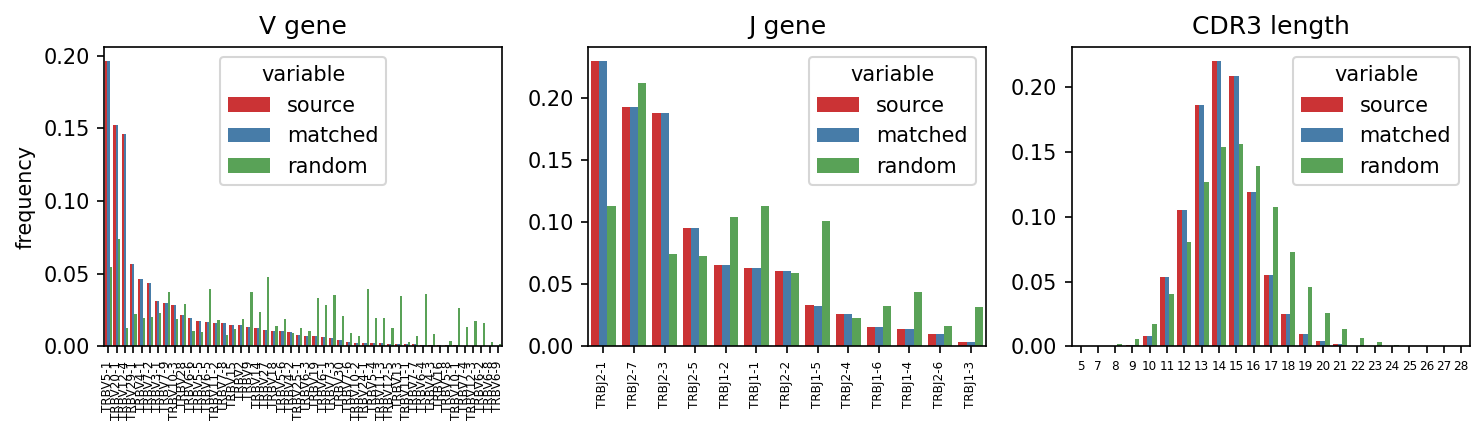

In [356]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set1')

v, j, length = compare_frequencies(df_a5s15, final, random_bg)

fig, ax = plt.subplots(dpi=150, nrows=1, ncols=3, figsize=(10,3))

sns.barplot(
    x='length',
    y='value',
    hue='variable',
    data=length,
    ax=ax[2]
    )

sns.barplot(
    x='v',
    y='value',
    hue='variable',
    data=v,
    ax=ax[0]
    )

sns.barplot(
    x='j',
    y='value',
    hue='variable',
    data=j,
    ax=ax[1]
    )

ax[0].set_ylabel('frequency')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_title('V gene')
ax[1].set_title('J gene')
ax[2].set_title('CDR3 length')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, fontsize='xx-small')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, fontsize='xx-small')
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize='xx-small')

fig.tight_layout()

In [29]:
import random

df = parse_britanova_repertoires('./data/britanova/A5-S15.txt.gz')
size_background = int(df.shape[0] * 10)

matched_background_a5s15 = directed_sampling(df=df, nsample=int(len(df)*10))

In [36]:
matched_background_a5s15

,junction,junction_aa,v_call,j_call
0,TGCGCCAGCAGCTTGGCCCGTGCCGGGACAGATGGTTACGTC,CASSLARAGTDGYV,TRBV5-1*01,TRBJ2-7*02
1,TGTGCCAGCAGCCGTTTTGTAGACCTGAGCACAGATACGCAGTATTTT,CASSRFVDLSTDTQYF,TRBV14*01,TRBJ2-3*01
2,TGCAGTGCTCCAACCGGGACGACCTACAATGAGCAGTTCTTC,CSAPTGTTYNEQFF,TRBV20-1*01,TRBJ2-1*01
3,TGTGCCAGCAGTTTGGCGCTTCATGAGCAGTTCTTC,CASSLALHEQFF,TRBV12-4*01,TRBJ2-1*01
4,TGCGCCAGCAGCCACCCGGGGGATCGTTTAACTTTTGAGACCCAGT...,CASSHPGDRLTFETQYF,TRBV4-1*01,TRBJ2-5*01
...,...,...,...,...
161595,TGTGCCAGCAGCTTAGGCGCTACCGGGGAGCTGTTTTTT,CASSLGATGELFF,TRBV7-2*02,TRBJ2-2*01
161596,TGTGCCAGCAGCCGGGACAGAATAGATACGCAGTATTTT,CASSRDRIDTQYF,TRBV7-2*01,TRBJ2-3*01
161597,TGCAGTGGGGAAAGTCAGTCCACAGATACGCAGTATTTT,CSGESQSTDTQYF,TRBV20-1*01,TRBJ2-3*01
161598,TGTGCCAGCAGCTCTACGCGGGGAGATACGCAGTATTTT,CASSSTRGDTQYF,TRBV7-2*02,TRBJ2-3*01


In [37]:


# matched_background = pd.read_csv('matched_background.csv')
# matched_background.head()

h = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
index = FlatIndex(hasher=h)
index.add(matched_background_a5s15)

ne = NeighborEnrichment(repertoire=df, hasher=h)
ne.compute_neighbors()

ne.bg_index = index
result_matched_bg = ne.compute_pvalues(exhaustive=True, prefilter=False)

ne.bg_index = None
result_random_bg = ne.compute_pvalues(exhaustive=True, prefilter=False)

Using background of size 161600.
Computing neighbor counts in background for 6467 sequences.
Performing hypergeometric testing.
Background index not set up.
Sampling background of size 161600.
Computing neighbor counts in background for 6467 sequences.
Performing hypergeometric testing.


In [73]:
result_matched_bg[result_matched_bg.pval<1e-7]

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval
4897,TRBV5-1*01,CASSLEVNTEAFF,25,11,1.997854e-18
144,TRBV5-1*01,CASSLDRNTEAFF,25,15,9.288729e-17
66,TRBV5-1*01,CASSLGLAGDNEQFF,19,4,9.997105e-17
4789,TRBV5-1*01,CASSLDVNTEAFF,24,13,1.089512e-16
3129,TRBV5-1*01,CASSLDLNTEAFF,22,10,3.155837e-16
...,...,...,...,...,...
189,TRBV5-1*01,CASSLQETQYF,19,34,9.091690e-08
5186,TRBV5-1*01,CASSLGQSYGYTF,14,16,9.276300e-08
3843,TRBV12-4*01,CASSLTGGTEAFF,14,16,9.276300e-08
118,TRBV12-4*01,CASSLANYGYTF,13,13,9.572469e-08


In [74]:
result_random_bg[result_random_bg.pval<1e-7]

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval
3206,TRBV5-1*01,CASSLEGDTQYF,33,15,1.147151e-23
2132,TRBV5-1*01,CASSLATDTQYF,34,17,1.168241e-23
76,TRBV12-4*01,CASSLGDTQYF,28,7,2.402695e-23
3332,TRBV5-1*01,CASSLNTDTQYF,28,9,3.700635e-22
3060,TRBV5-1*01,CASSLGGSYNEQFF,36,26,5.937711e-22
...,...,...,...,...,...
676,TRBV12-4*01,CASSQTYEQYF,18,30,8.869653e-08
2785,TRBV5-1*01,CASSPGSSTDTQYF,14,16,9.276300e-08
2855,TRBV5-1*01,CASSLVQGAYEQYF,13,13,9.572469e-08
2861,TRBV12-4*01,CASSLWAYEQYF,13,13,9.572469e-08


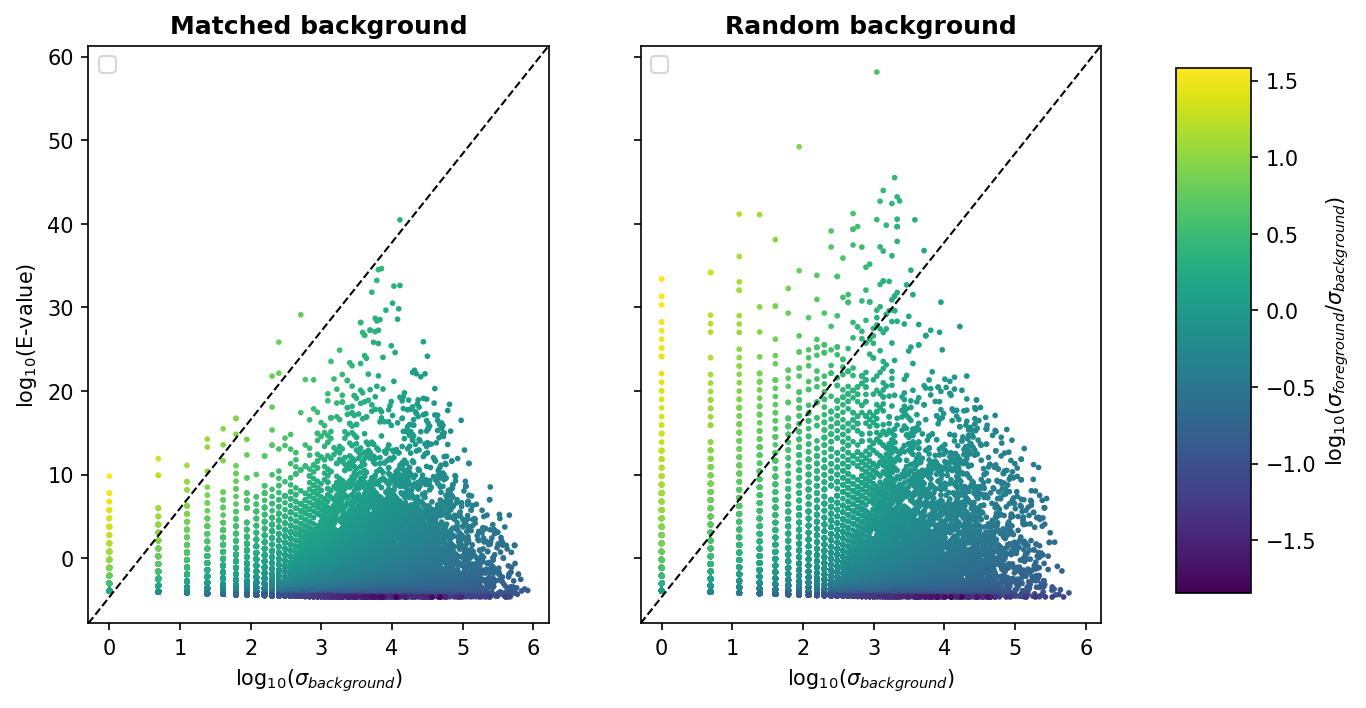

In [12]:
import numpy as np

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5), dpi=150, sharex=True, sharey=True)

rat = np.log10(result_matched_bg['foreground_neighbors'] / result_matched_bg['background_neighbors'])
cbar = ax[0].scatter(
    x=np.log(result_matched_bg['background_neighbors']), 
    y=-np.log10(result_matched_bg['pval']*len(df)),
    c=rat,
    edgecolor=None,
    cmap='viridis',
    s=3
    )

rat = np.log10(result_random_bg['foreground_neighbors'] / result_random_bg['background_neighbors'])
cbar = ax[1].scatter(
    x=np.log(result_random_bg['background_neighbors']), 
    y=-np.log10(result_random_bg['pval']*len(df)),
    c=rat,
    edgecolor=None,
    cmap='viridis',
    s=3
    )

# fig.colorbar(cbar, label=r'$log_{10}$($\sigma_{foreground}$/$\sigma_{background}$)')
# cbar.set_clim(-.6,1.75)

ax[0].set_xlabel(r'log$_{10}$($\sigma_{background}$)')
ax[1].set_xlabel(r'log$_{10}$($\sigma_{background}$)')

ax[0].set_ylabel(r'log$_{10}$(E-value)')
# ax[1].set_ylabel(r'log$_{10}$(E-value)')

ax[0].legend('')
ax[1].legend('')

ax[0].set_title('Matched background', weight='bold')
ax[1].set_title('Random background', weight='bold')

ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, ls='--', c='black', lw=1)
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes, ls='--', c='black', lw=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cbar, cax=cbar_ax, label=r'log$_{10}$($\sigma_{foreground}$/$\sigma_{background}$)')

In [87]:
result_matched_bg['v_gene'] = result_matched_bg.v_call.apply(lambda x: x.split('*')[0])
result_random_bg['v_gene'] = result_random_bg.v_call.apply(lambda x: x.split('*')[0])

result_matched_bg['logpval'] = -np.log10(result_matched_bg.pval)
result_random_bg['logpval'] = -np.log10(result_random_bg.pval)

In [174]:
len(result_matched_bg.v_gene.unique())
# len(result_random_bg.v_gene.unique())

31

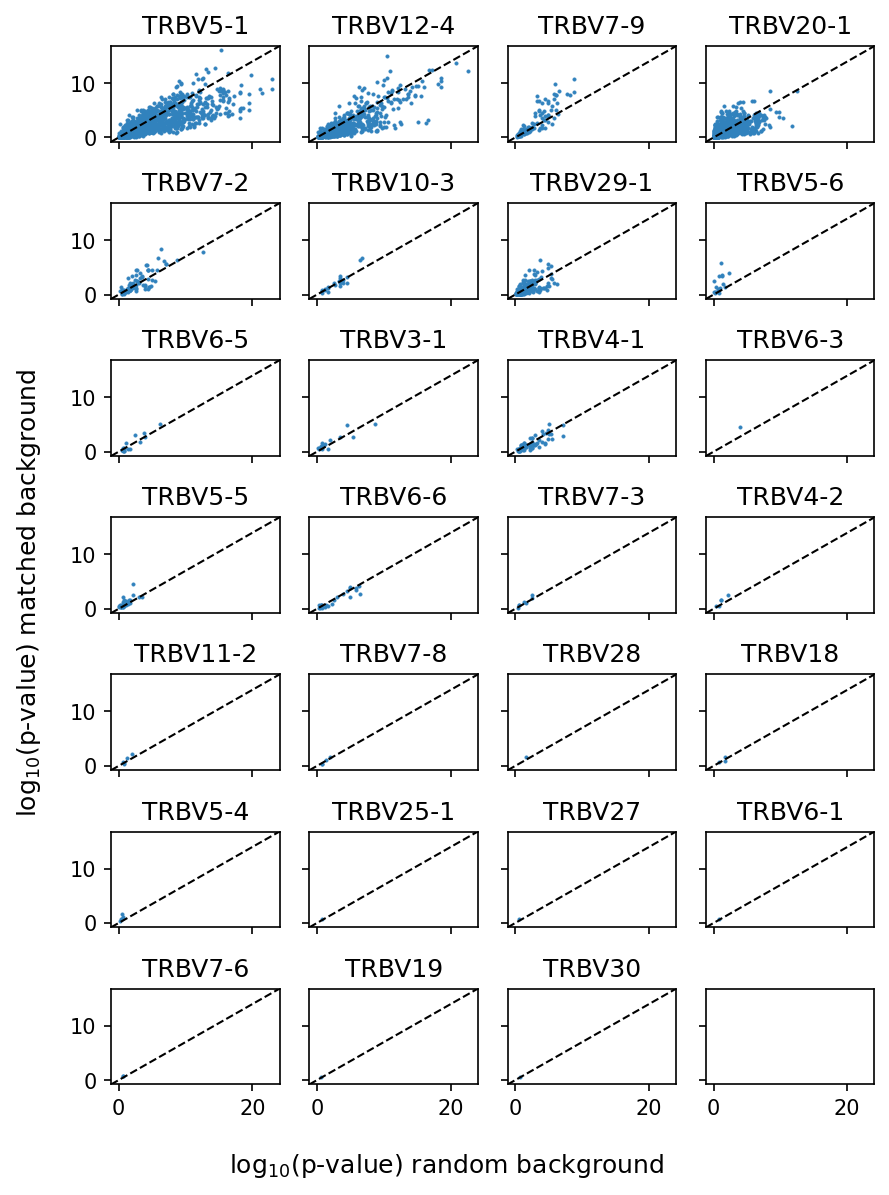

In [169]:
from scipy import stats

allres = result_matched_bg.merge(result_random_bg, on=['junction_aa', 'v_gene'])

fig, axes = plt.subplots(dpi=150, nrows=7, ncols=4, sharex=True, sharey=True, figsize=(6,8))

for v, ax in zip(allres.v_gene.unique(), axes.flatten()):
    v_sub = allres[allres.v_gene==v]

# x = -np.log10(allres['pval_y'])
# y = -np.log10(allres['pval_x'])

# xy = np.vstack([x,y])
# z = stats.gaussian_kde(xy)(xy)

    sns.scatterplot(
        y='logpval_x',
        x='logpval_y',
        data=v_sub,
        s=3,
        edgecolor=None,
        ax=ax
    )

    ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c='black', lw=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(v)
# ax.legend(fontsize=4)

fig.supxlabel(r'log$_{10}$(p-value) random background')
fig.supylabel(r'log$_{10}$(p-value) matched background')

fig.tight_layout()
fig.savefig('./fig/matched_vs_random_vgene.png', format='png', dpi=500)

### Matched background model

In [12]:
mtch_bckgrnd = matched_property_sampling(repertoire=df, total=size_background, chunksize=3000, ncpus=8)

0
300000


In [49]:
import numpy as np

def add_gene_cols(df):
    df['v_gene'] = df['v_call'].apply(lambda x: x.split('*')[0])
    df['j_gene'] = df['j_call'].apply(lambda x: x.split('*')[0])
    return df

def diff_co_occurrence(df1, df2):

    if 'v_gene' not in df1:
        df1 = add_gene_cols(df1)
    if 'v_gene' not in df2:
        df2 = add_gene_cols(df2)

    co_occurrence_1 = pd.crosstab(df1['j_gene'], df1['v_gene']) / len(df1)
    co_occurrence_2 = pd.crosstab(df2['j_gene'], df2['v_gene']) / len(df2)

    vgenes = sorted(co_occurrence_1.columns)
    jgenes = sorted(co_occurrence_1.index)

    X_fg = co_occurrence_1[vgenes].sort_index().to_numpy()
    X_bg = co_occurrence_2[vgenes].sort_index().to_numpy()

    return pd.DataFrame(np.subtract(X_fg, X_bg), columns=vgenes, index=jgenes)

df_a5s14 = parse_britanova_repertoires('./data/britanova/A5-S14.txt.gz')
df_a5s15 = parse_britanova_repertoires('./data/britanova/A5-S15.txt.gz')

matched_background_a5s14 = pd.read_csv('./matched_background.csv')

a5s14 = diff_co_occurrence(df_a5s14, matched_background_a5s14)
a5s15 = diff_co_occurrence(df_a5s15, matched_background_a5s15)



# df = parse_britanova_repertoires('./data/britanova/A5-S14.txt.gz')


# fig.colorbar(im, label='diff')

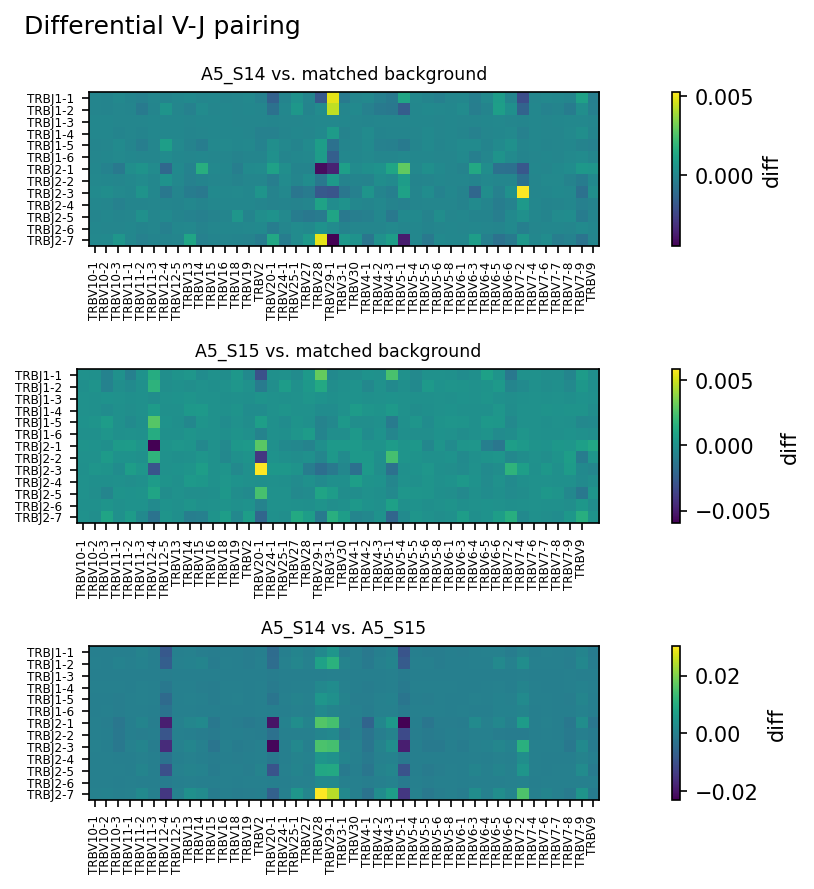

In [65]:
fig, ax = plt.subplots(dpi=150, figsize=(10,6), nrows=3)

im = ax[0].imshow(a5s14)
ax[0].set_xticks(range(len(vgenes)))
ax[0].set_xticklabels(vgenes, rotation=90, fontsize='xx-small')
ax[0].set_yticks(range(len(jgenes)))
ax[0].set_yticklabels(jgenes, fontsize='xx-small')
ax[0].set_title('A5_S14 vs. matched background', fontsize='small')

fig.colorbar(im, label='diff')

im = ax[1].imshow(a5s15)
ax[1].set_xticks(range(len(vgenes)))
ax[1].set_xticklabels(vgenes, rotation=90, fontsize='xx-small')
ax[1].set_yticks(range(len(jgenes)))
ax[1].set_yticklabels(jgenes, fontsize='xx-small')
ax[1].set_title('A5_S15 vs. matched background', fontsize='small')

fig.colorbar(im, label='diff')

im = ax[2].imshow(diff_co_occurrence(df_a5s14, df_a5s15))
ax[2].set_xticks(range(len(vgenes)))
ax[2].set_xticklabels(vgenes, rotation=90, fontsize='xx-small')
ax[2].set_yticks(range(len(jgenes)))
ax[2].set_yticklabels(jgenes, fontsize='xx-small')
ax[2].set_title('A5_S14 vs. A5_S15', fontsize='small')

fig.colorbar(im, label='diff')
fig.suptitle('Differential V-J pairing')

fig.tight_layout()

In [176]:
df_a2i129 = parse_britanova_repertoires('./data/britanova/A2-i129.txt.gz')

directed

**V gene**

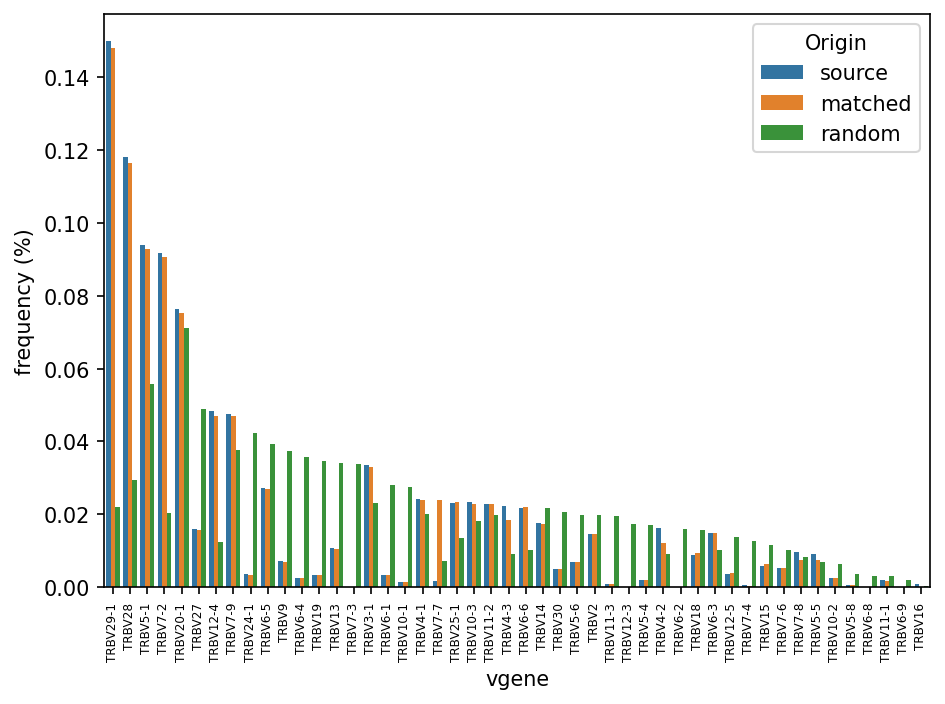

In [44]:
v_r = pd.DataFrame.from_dict(v_random, orient='index', columns=['random']).sort_index()
v_m = pd.DataFrame.from_dict(v_matched, orient='index', columns=['matched']).sort_index()
v_s = pd.DataFrame.from_dict(v_source, orient='index', columns=['source']).sort_index()

v = pd.concat([v_r, v_m, v_s], axis=1).fillna(0).reset_index().rename(columns={'index':'vgene'})
v = pd.melt(v, id_vars=['vgene'], value_vars=['random','matched','source']).sort_values(by='value', ascending=False)

fig, ax = plt.subplots(dpi=150)

sns.barplot(x='vgene',y='value',hue='variable',data=v, ax=ax)
xticks = ax.get_xticklabels()
ax.set_xticklabels(xticks, rotation=90, fontsize='xx-small')
ax.set_ylabel('frequency (%)')
ax.legend(title='Origin')

fig.tight_layout()

**J gene**

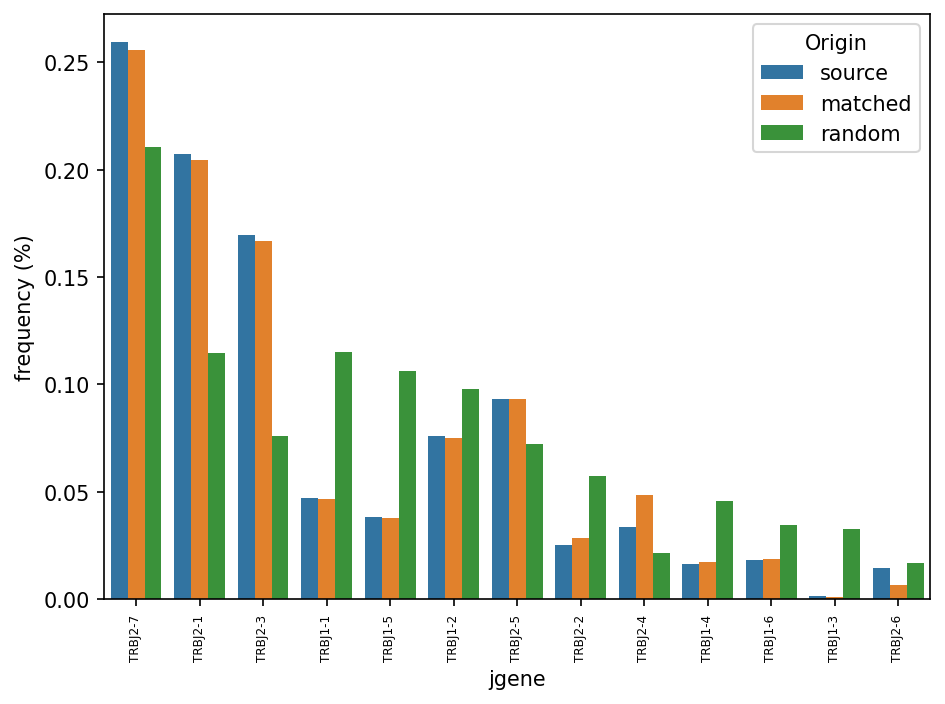

In [46]:
j_r = pd.DataFrame.from_dict(j_random, orient='index', columns=['random']).sort_index()
j_m = pd.DataFrame.from_dict(j_matched, orient='index', columns=['matched']).sort_index()
j_s = pd.DataFrame.from_dict(j_source, orient='index', columns=['source']).sort_index()

j = pd.concat([j_r, j_m, j_s], axis=1).fillna(0).reset_index().rename(columns={'index':'jgene'})
j = pd.melt(j, id_vars=['jgene'], value_vars=['random','matched','source']).sort_values(by='value', ascending=False)

fig, ax = plt.subplots(dpi=150)

sns.barplot(x='jgene',y='value',hue='variable',data=j, ax=ax)
xticks = ax.get_xticklabels()
ax.set_xticklabels(xticks, rotation=90, fontsize='xx-small')
ax.set_ylabel('frequency (%)')
ax.legend(title='Origin')

fig.tight_layout()

**length**

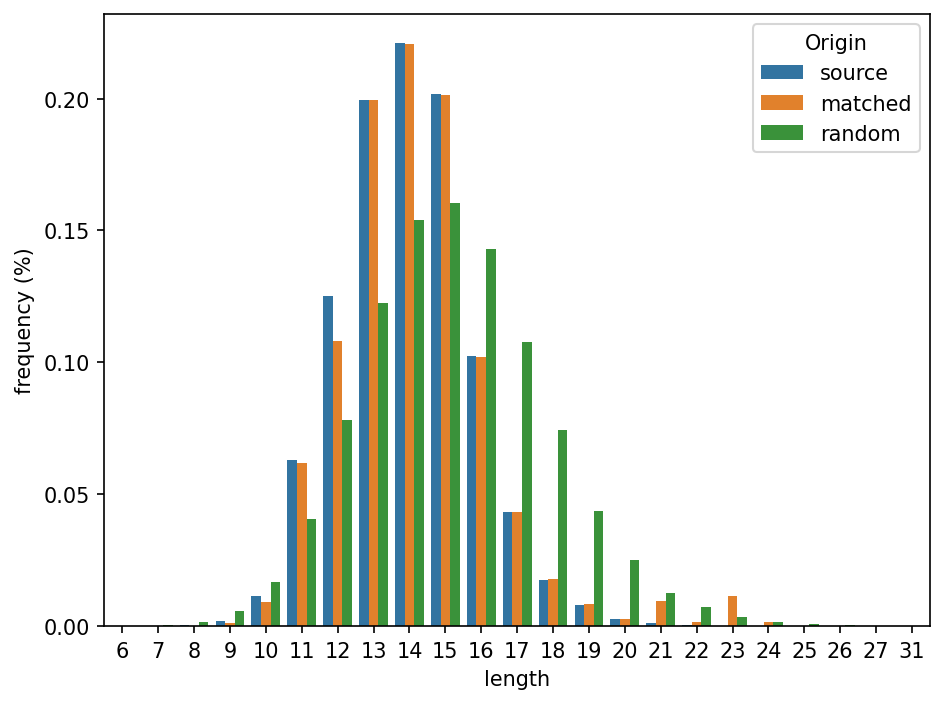

In [58]:
l_r = pd.DataFrame.from_dict(len_random, orient='index', columns=['random']).sort_index()
l_m = pd.DataFrame.from_dict(len_matched, orient='index', columns=['matched']).sort_index()
l_s = pd.DataFrame.from_dict(len_source, orient='index', columns=['source']).sort_index()

l = pd.concat([l_r, l_m, l_s], axis=1).fillna(0).reset_index().rename(columns={'index':'length'})
l = pd.melt(l, id_vars=['length'], value_vars=['random','matched','source']).sort_values(by='value', ascending=False)

fig, ax = plt.subplots(dpi=150)

sns.barplot(x='length',y='value',hue='variable',data=l, ax=ax)
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks, rotation=90, fontsize='xx-small')
ax.set_ylabel('frequency (%)')
ax.legend(title='Origin')

fig.tight_layout()